In [1]:
# Aidan O'Hara ee508 final project
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
from rasterio import open as r_open
import rasterio as rast
from rasterio.features import geometry_window as r_geo
from rasterio.plot import show as r_show
from subprocess import Popen
from rasterstats import zonal_stats

In [2]:
def ff(x):
    return 'D:\\EE508_Final_Data\\' + x


# Data Wrangling, all data required

In [3]:
naics = pd.read_csv(ff('cbp21co\\cbp21co.csv'))

In [4]:
naics.head()

,fipstate,fipscty,naics,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
0,1,1,------,G,11216,G,97944,G,424826,924,...,100,31,8,N,N,N,N,N,N,N
1,1,1,11----,G,78,G,1325,G,5107,10,...,N,N,N,N,N,N,N,N,N,N
2,1,1,113///,G,68,G,1213,G,4563,7,...,N,N,N,N,N,N,N,N,N,N
3,1,1,1133//,G,68,G,1213,G,4563,7,...,N,N,N,N,N,N,N,N,N,N
4,1,1,11331/,G,68,G,1213,G,4563,7,...,N,N,N,N,N,N,N,N,N,N


In [5]:
# https://a3e.com/naics-codes-for-environmentally-sensitive-industries/
envNaics = pd.read_csv(ff('environmentallySensitiveNAICS.csv'), header = None)

In [6]:
envNaics = envNaics.fillna('')

In [7]:
envNaics[0] = envNaics[0] + envNaics[1] + envNaics[2]

In [8]:
envNaics = envNaics.drop(columns = [1,2])
envNaics[['code', 'desc']] = envNaics[0].str.split('\xa0', n=1, expand = True)

In [9]:
envNaics['code'] = envNaics['code'].astype('str')

In [10]:
env_naics_selected = naics[naics['naics'].str.startswith(tuple(envNaics['code']))]

In [11]:
env_naics_selected

,fipstate,fipscty,naics,emp_nf,emp,qp1_nf,qp1,ap_nf,ap,est,...,n20_49,n50_99,n100_249,n250_499,n500_999,n1000,n1000_1,n1000_2,n1000_3,n1000_4
8,1,1,212///,G,87,G,1224,G,5144,6,...,N,N,N,N,N,N,N,N,N,N
9,1,1,2123//,G,87,G,1224,G,5144,6,...,N,N,N,N,N,N,N,N,N,N
10,1,1,21232/,G,87,G,1224,G,5144,6,...,N,N,N,N,N,N,N,N,N,N
11,1,1,212321,G,87,G,1224,G,5144,6,...,N,N,N,N,N,N,N,N,N,N
24,1,1,237///,G,96,H,1444,H,6161,7,...,3,N,N,N,N,N,N,N,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1090055,56,999,213112,J,688,J,13080,J,50868,6,...,N,N,N,N,N,N,N,N,N,N
1090056,56,999,213114,J,3,J,197,J,1492,3,...,N,N,N,N,N,N,N,N,N,N
1090078,56,999,484///,G,13,H,187,H,961,4,...,N,N,N,N,N,N,N,N,N,N
1090155,56,999,8112//,J,11,J,299,J,1927,3,...,N,N,N,N,N,N,N,N,N,N


In [12]:
count_env_naics = env_naics_selected.groupby(['fipstate','fipscty'])['ap'].agg(['sum', 'count']).reset_index()

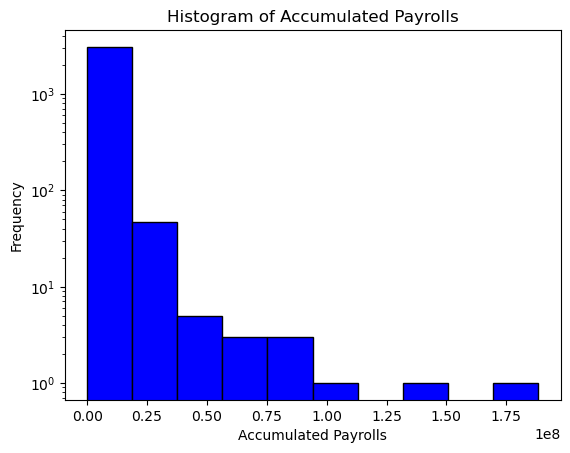

In [13]:

# Plotting the histogram
plt.hist(count_env_naics['sum'], bins=10, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('Accumulated Payrolls')
plt.ylabel('Frequency')
plt.title('Histogram of Accumulated Payrolls')
plt.yscale('log')

# Show the plot
plt.show()

In [14]:
count_env_naics['fipstate'] = count_env_naics['fipstate'].astype(str).str.zfill(2)
count_env_naics['fipscty'] = count_env_naics['fipscty'].astype(str).str.zfill(3)
count_env_naics['totalfips'] = count_env_naics['fipstate'] + count_env_naics['fipscty']

In [15]:
count_env_naics

,fipstate,fipscty,sum,count,totalfips
0,01,001,122001,48,01001
1,01,003,2011003,212,01003
2,01,005,279331,38,01005
3,01,007,112772,35,01007
4,01,009,263936,73,01009
...,...,...,...,...,...
3123,56,039,330983,85,56039
3124,56,041,182646,46,56041
3125,56,043,52079,31,56043
3126,56,045,43828,34,56045


In [16]:
# time to bring in my counties?

In [17]:
ruralCapcityIndex = pd.read_excel(ff('HE_Rural_Capacity_Index_May_2023_Download_Data.xlsx'),
                                 sheet_name = '1. County')


In [18]:
ruralCapcityIndex['FIPS'] = ruralCapcityIndex['FIPS'].astype(str).str.zfill(5)

In [19]:
ruralCapcityIndex

,FIPS,NAME,STATE,RURAL CAPACITY INDEX,PERCENT OF COUNTIES NATIONWIDE WITH HIGHER CAPACITY
0,01001,"Autauga County, AL",AL,63.22,0.505886
1,01003,"Baldwin County, AL",AL,75.37,0.116767
2,01005,"Barbour County, AL",AL,52.62,0.738466
3,01007,"Bibb County, AL",AL,56.97,0.667833
4,01009,"Blount County, AL",AL,50.54,0.790646
...,...,...,...,...,...
3138,56037,"Sweetwater County, WY",WY,69.61,0.358575
3139,56039,"Teton County, WY",WY,76.08,0.091314
3140,56041,"Uinta County, WY",WY,72.86,0.223353
3141,56043,"Washakie County, WY",WY,62.78,0.515113


In [20]:
ri = ruralCapcityIndex

In [21]:
count_env_naics['FIPS'] = count_env_naics['totalfips']

In [22]:
ena = count_env_naics[['FIPS','sum','count']]

In [23]:
more = pd.merge(ri, ena, on = 'FIPS', how = 'left')

In [24]:
more

,FIPS,NAME,STATE,RURAL CAPACITY INDEX,PERCENT OF COUNTIES NATIONWIDE WITH HIGHER CAPACITY,sum,count
0,01001,"Autauga County, AL",AL,63.22,0.505886,122001.0,48.0
1,01003,"Baldwin County, AL",AL,75.37,0.116767,2011003.0,212.0
2,01005,"Barbour County, AL",AL,52.62,0.738466,279331.0,38.0
3,01007,"Bibb County, AL",AL,56.97,0.667833,112772.0,35.0
4,01009,"Blount County, AL",AL,50.54,0.790646,263936.0,73.0
...,...,...,...,...,...,...,...
3138,56037,"Sweetwater County, WY",WY,69.61,0.358575,1792317.0,102.0
3139,56039,"Teton County, WY",WY,76.08,0.091314,330983.0,85.0
3140,56041,"Uinta County, WY",WY,72.86,0.223353,182646.0,46.0
3141,56043,"Washakie County, WY",WY,62.78,0.515113,52079.0,31.0


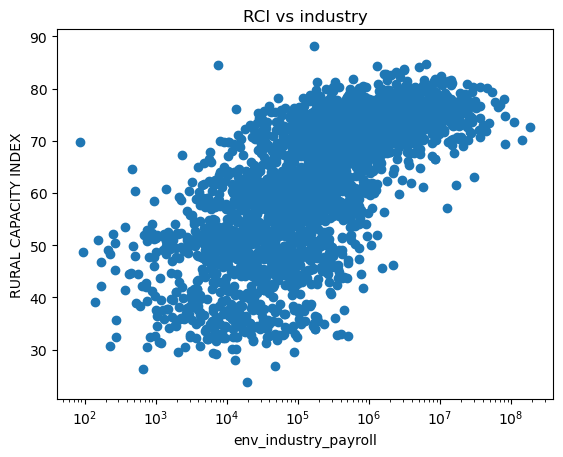

In [25]:
plt.scatter(more['sum'], more['RURAL CAPACITY INDEX'])

# Adding labels and title
plt.xlabel('env_industry_payroll')
plt.ylabel('RURAL CAPACITY INDEX')
plt.title('RCI vs industry')
plt.xscale('log')
# Show the plot
plt.show()

In [26]:
county = gpd.read_file(ff('tl_2023_us_county\\tl_2023_us_county.shp'))


In [27]:
states_to_remove = ['02','15','60','66','69','72','74','78']

In [28]:
cont = county[~county['STATEFP'].isin(states_to_remove)]

In [29]:
cont['FIPS'] = cont['STATEFP'] + cont['COUNTYFP']

C:\Users\aidan\anaconda3\lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [30]:
cont = cont.set_index('FIPS')

In [31]:
more.set_index('FIPS')

,NAME,STATE,RURAL CAPACITY INDEX,PERCENT OF COUNTIES NATIONWIDE WITH HIGHER CAPACITY,sum,count
FIPS,,,,,,
01001,"Autauga County, AL",AL,63.22,0.505886,122001.0,48.0
01003,"Baldwin County, AL",AL,75.37,0.116767,2011003.0,212.0
01005,"Barbour County, AL",AL,52.62,0.738466,279331.0,38.0
01007,"Bibb County, AL",AL,56.97,0.667833,112772.0,35.0
01009,"Blount County, AL",AL,50.54,0.790646,263936.0,73.0
...,...,...,...,...,...,...
56037,"Sweetwater County, WY",WY,69.61,0.358575,1792317.0,102.0
56039,"Teton County, WY",WY,76.08,0.091314,330983.0,85.0
56041,"Uinta County, WY",WY,72.86,0.223353,182646.0,46.0


In [32]:
more['rci'] = more['RURAL CAPACITY INDEX']

In [33]:
costInfo = more[['FIPS','sum','count', 'rci']].set_index('FIPS')

In [34]:
contPlus = cont.join(costInfo)


In [35]:
contPlus['sum'] = contPlus['sum'].fillna(0)
contPlus['count'] = contPlus['count'].fillna(0)

<AxesSubplot:>

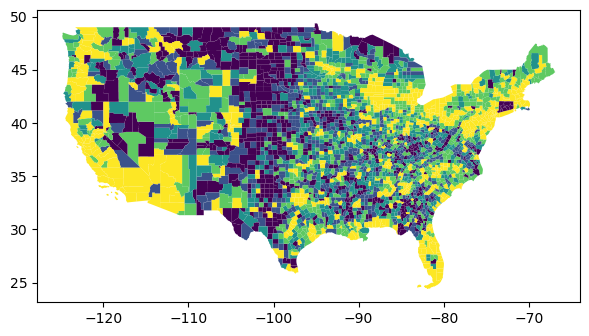

In [36]:
contPlus.plot('count', scheme='quantiles', figsize=(7, 4), legend=False)

<AxesSubplot:>

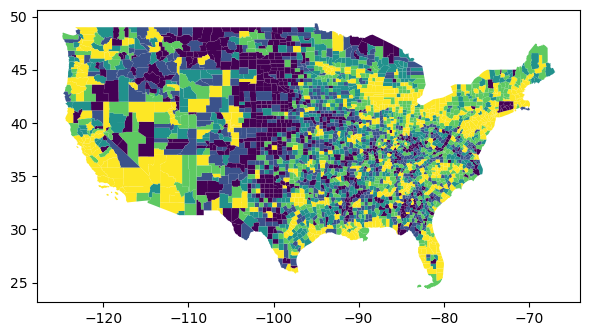

In [37]:
contPlus.plot('sum', scheme='quantiles', figsize=(7, 4), legend=False)

<AxesSubplot:>

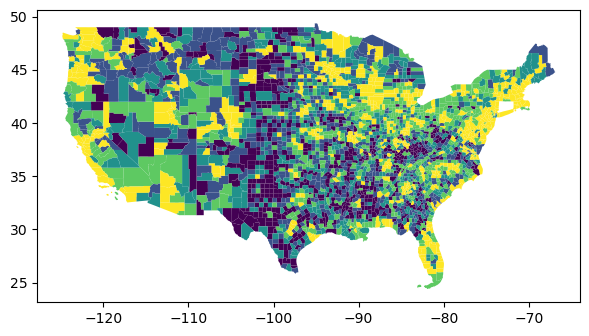

In [38]:
contPlus.plot('rci', scheme='quantiles', figsize=(7, 4), legend=False)

In [39]:
contPlus['km2'] = contPlus.to_crs('epsg:6933').area

<AxesSubplot:>

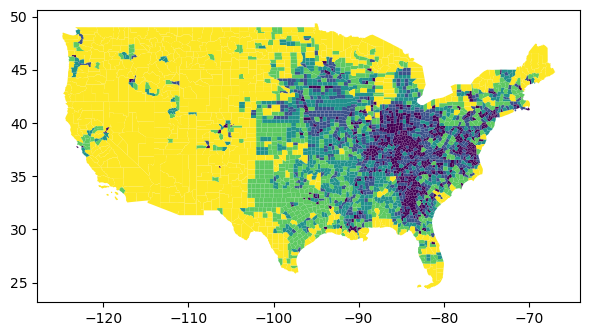

In [40]:
contPlus.plot('km2', scheme='quantiles', figsize=(7, 4), legend=False)

In [41]:
contPlus.total_bounds

array([-124.848974,   24.396308,  -66.885444,   49.384479])

In [42]:
r_file = r_open(ff('conus_fores_biomass_mg_per_ha_reproj.tif')) # read tif
r = r_file.read(1)

#r_show(r)

In [43]:
r[r < 0] = 0

In [44]:
# fig, ax = plt.subplots()

# contPlus.plot(edgecolor='white', figsize=(10, 10), ax=ax)

# r_show(r, cmap='viridis_r', ax = ax, alpha = 0.5)

# # Plot the raster on top of the GeoPandas outline
# plt.show()


In [45]:
# coarsen my polygons
contPlus_simplified = contPlus.copy()
contPlus_simplified['geometry'] = contPlus['geometry'].simplify(0.005)

In [46]:
contPlus_simplified_temp = contPlus_simplified[contPlus_simplified['STATEFP'] == '19'].copy()
contPlus_temp = contPlus[contPlus['STATEFP'] == '19'].copy()

In [47]:
%%time

r_file = rast.open(ff('conus_fores_biomass_mg_per_ha_reproj.tif')) # read tif
r = r_file.read(1)
r[r <= 0] = 0

Wall time: 13.1 s


In [48]:
%%time


zs = zonal_stats(
    contPlus_simplified,
    r,
    affine = r_file.transform,
    stats = ['sum'],
    all_touched = False,
    #nodata = 0
)


cPS = pd.DataFrame(zs, index = contPlus_simplified.index)
contPlus['biomass'] = cPS['sum']

C:\Users\aidan\anaconda3\lib\site-packages\rasterstats\io.py:328: NodataWarning: Setting nodata to -999; specify nodata explicitly
  warnings.warn(


Wall time: 7.87 s


<AxesSubplot:>

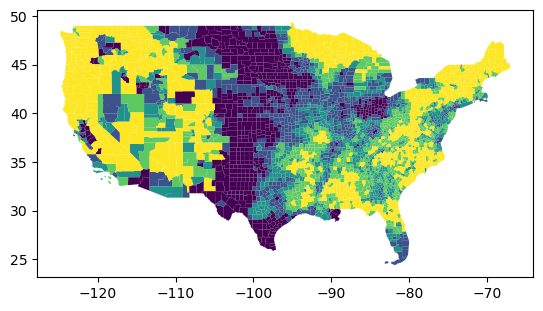

In [49]:
contPlus.plot(column = 'biomass', scheme = 'quantiles')

In [50]:
# collapse my rasters into the polygons

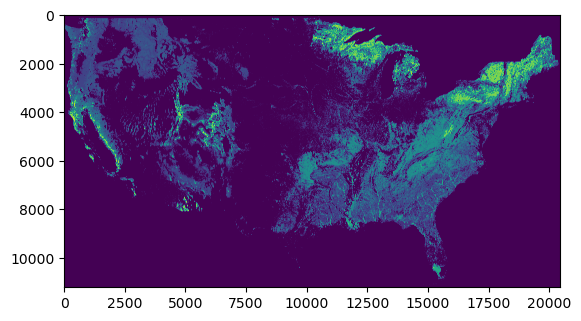

Wall time: 10.5 s


<AxesSubplot:>

In [51]:
%%time

r_file = rast.open(ff('conus_forestgroup_reproj.tif')) # read tif
r = r_file.read(1)
r_show(r)

In [52]:
np.unique(r)

array([  0, 100, 120, 140, 160, 180, 200, 220, 240, 260, 280, 300, 320,
       340, 360, 370, 380, 400, 500, 600, 700, 800, 900, 910, 920, 940,
       950, 980, 990], dtype=uint16)

In [53]:
r_all = r > -1

zs = zonal_stats(
    contPlus_simplified,
    r_all,
    affine = r_file.transform,
    stats = ['sum'],
    all_touched = False,
    #nodata = 0
)


cPS_count = pd.DataFrame(zs, index = contPlus_simplified.index)
contPlus['pixArea'] = cPS_count['sum']

In [54]:
r_type1 = r == 100
r_type1 = r_type1.astype('int')
zs = zonal_stats(
    contPlus_simplified,
    r_type1,
    affine = r_file.transform,
    stats = ['sum'],
    all_touched = False,
    #nodata = 0
)


cPS_count_type1 = pd.DataFrame(zs, index = contPlus_simplified.index)
contPlus['pixArea_type1'] = cPS_count_type1['sum']
contPlus['propType1'] = contPlus['pixArea_type1']/contPlus['pixArea']

In [55]:
contPlus['propType1'].min()

0.0

In [56]:
contPlus

,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,INTPTLON,geometry,sum,count,rci,km2,biomass,pixArea,pixArea_type1,propType1
FIPS,,,,,,,,,,,,,,,,,,,,,
31039,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,...,-096.7885168,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",73933.0,35.0,60.07,1.488336e+09,1.561278e+04,25448.0,0.0,0.000000
53069,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,...,-123.4244583,"POLYGON ((-123.72755 46.26449, -123.72755 46.2...",875.0,2.0,54.01,7.425456e+08,2.306748e+06,13856.0,0.0,0.000000
35011,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,...,-104.3686961,"POLYGON ((-104.89337 34.08894, -104.89337 34.0...",0.0,0.0,40.80,6.045910e+09,0.000000e+00,93894.0,0.0,0.000000
31109,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,...,-096.6886584,"POLYGON ((-96.68493 40.52330, -96.69219 40.523...",5834061.0,233.0,77.42,2.192120e+09,5.499508e+04,37094.0,0.0,0.000000
31129,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,...,-098.0468422,"POLYGON ((-98.27370 40.11840, -98.27374 40.122...",8601.0,18.0,49.80,1.491364e+09,6.451248e+04,24960.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,13,123,00351260,13123,0500000US13123,Gilmer,Gilmer County,06,H1,G4020,...,-084.4548113,"POLYGON ((-84.30237 34.57832, -84.30329 34.577...",121074.0,48.0,50.73,1.116170e+09,2.465294e+06,17399.0,30.0,0.001724
27135,27,135,00659513,27135,0500000US27135,Roseau,Roseau County,06,H1,G4020,...,-095.8215042,"POLYGON ((-95.25857 48.88666, -95.25707 48.885...",179998.0,27.0,61.67,4.346613e+09,8.722275e+05,84038.0,1190.0,0.014160
28089,28,089,00695768,28089,0500000US28089,Madison,Madison County,06,H1,G4020,...,-090.0341603,"POLYGON ((-90.14883 32.40026, -90.14890 32.400...",1271016.0,125.0,77.73,1.921876e+09,1.896139e+06,29181.0,0.0,0.000000


In [57]:

#value in np.unique(r)
#if value != 0

for value in np.unique(r):
    if value != 0:
        r_this = r == value
        r_this = r_this.astype('int')
        zs = zonal_stats(
            contPlus_simplified,
            r_this,
            affine = r_file.transform,
            stats = ['sum'],
            all_touched = False,
            #nodata = 0
        )


        cPS_this = pd.DataFrame(zs, index = contPlus_simplified.index)
        contPlus['forestPixArea' + value.astype('str')] = cPS_this['sum']
        contPlus['forestProp' + value.astype('str')] = cPS_this['sum']/contPlus['pixArea']
        print(value)
        
contPlus.head()

100
120
140
160
180
200
220
240
260
280
300
320
340
360
370
380
400
500
600
700
800
900
910
920
940
950
980
990


,STATEFP,COUNTYFP,COUNTYNS,GEOID,GEOIDFQ,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,...,forestPixArea920,forestProp920,forestPixArea940,forestProp940,forestPixArea950,forestProp950,forestPixArea980,forestProp980,forestPixArea990,forestProp990
FIPS,,,,,,,,,,,,,,,,,,,,,
31039,31,039,00835841,31039,0500000US31039,Cuming,Cuming County,06,H1,G4020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53069,53,069,01513275,53069,0500000US53069,Wahkiakum,Wahkiakum County,06,H1,G4020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
35011,35,011,00933054,35011,0500000US35011,De Baca,De Baca County,06,H1,G4020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31109,31,109,00835876,31109,0500000US31109,Lancaster,Lancaster County,06,H1,G4020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
31129,31,129,00835886,31129,0500000US31129,Nuckolls,Nuckolls County,06,H1,G4020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [58]:
forestAreaColumns = ['forestPixArea' + value.astype('str') for value in np.unique(r[r != 0])]

In [59]:
# sum across fores pix areas to make total forested pix
contPlus['forestPixArea'] = contPlus[forestAreaColumns].sum(axis = 1) #df[columns_to_sum].sum(axis=1)


In [60]:
contPlus['biomass_density'] = contPlus['biomass']/contPlus['forestPixArea']

In [61]:
# contPlus['biomass_density'] = contPlus['biomass_density'].replace([np.inf, -np.inf], np.nan, inplace=True)# df.replace([np.inf, -np.inf], np.nan, inplace=True)
# contPlus['biomass_density'] = contPlus['biomass_density'].fillna(0)

contPlus['biomass_density'].replace(np.inf, 0, inplace = True)
contPlus['biomass_density'].replace(np.nan, 0, inplace = True)

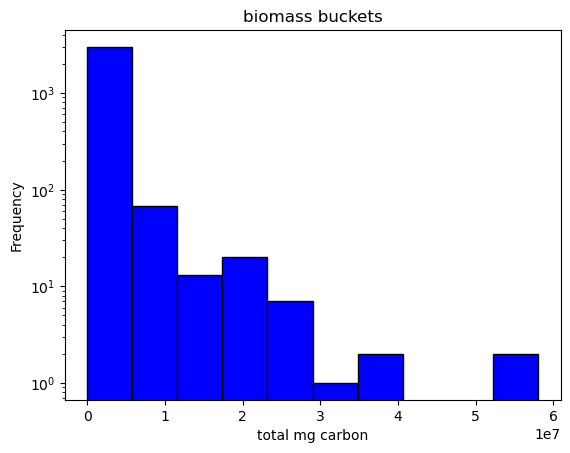

In [62]:
# Plotting the histogram
plt.hist(contPlus['biomass_density']*contPlus['forestPixArea'], bins=10, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('total mg carbon')
plt.ylabel('Frequency')
plt.title('biomass buckets')
plt.yscale('log')

# Show the plot
plt.show()

<AxesSubplot:>

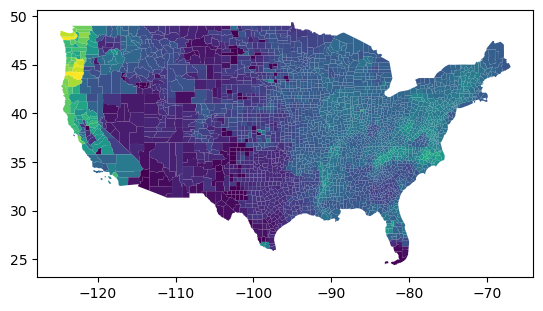

In [63]:
contPlus.plot('biomass_density')

In [64]:
contPlus['biomass_density']

FIPS
31039     89.728645
53069    201.638767
35011      0.000000
31109     62.995512
31129     80.339323
            ...    
13123    147.340067
27135     57.375839
28089    124.680390
48227     18.627953
54099    107.706364
Name: biomass_density, Length: 3109, dtype: float64

In [65]:
forestBiomassColumns = ['forestBiomass' + value.astype('str') for value in np.unique(r[r != 0])]

In [66]:
# the carbon density times the number of pixels of forest
#[contPlus['forestBiomass' + value.astype('str')] = contPlus['forestPixArea' + value.astype('str')]*contPlus['biomass_density'] for value in np.unique(r[r != 0])]

for value in np.unique(r[r != 0]):
    contPlus['forestBiomass' + value.astype('str')] = contPlus['forestPixArea' + value.astype('str')]*contPlus['biomass_density']

<AxesSubplot:>

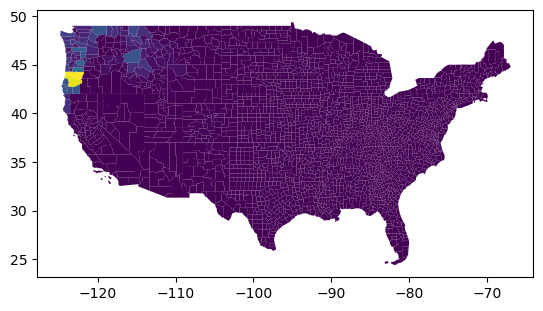

In [67]:
contPlus.plot(column = 'forestBiomass200')

<AxesSubplot:>

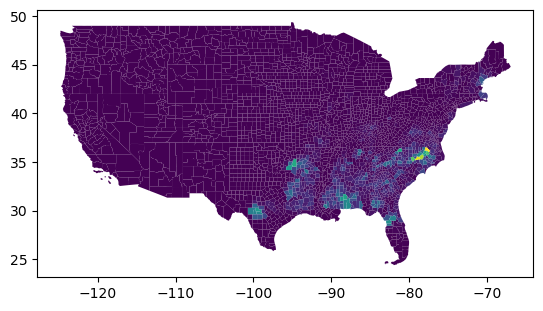

In [68]:
contPlus.plot(column = 'forestBiomass400')

In [69]:
contPlus['rci'] = contPlus['rci'].fillna(10)

In [70]:
final_data_out = pd.DataFrame(contPlus.drop(columns='geometry'))
final_data_out.to_csv(ff("final_county_data.csv"))

# MARXAN, only requires geometry merge

In [71]:
contPlus = pd.read_csv(ff("final_county_data.csv"))
contPlus['FIPS'] = contPlus['FIPS'].astype('str').str.zfill(5)
contPlus = contPlus.set_index('FIPS')

In [72]:
# cost will be
# $ price of half the carbon in the pu + transaction cost of protection, based on rci and flat rate, and an "industry offset" based on 10 years of annual payroll
# density * total forest pix *  10 price per megagram carbon, + 150000 * ()

# https://scholarworks.uni.edu/cgi/viewcontent.cgi?article=2104&context=etd

In [73]:
minimum_transaction = 1500000
maxRCI = 100
RCIPenalty = 500000
costPerMGCarbon = 10
yearToPayIndustry = 10
cont_PU = contPlus.copy()
cont_PU['status'] = 0
cont_PU['cost'] = (contPlus['biomass_density']*contPlus['forestPixArea']*costPerMGCarbon) + \
                  (minimum_transaction + (maxRCI - contPlus['rci'])*RCIPenalty) + \
                  (yearToPayIndustry*contPlus['sum'])

In [74]:
cont_PU['cost'] = (cont_PU['cost']/1000000).round(3)

In [75]:
cont_PU.loc[['09110'],['rci']]

,rci
FIPS,
09110,10.0


In [76]:
(contPlus['biomass_density']*contPlus['forestPixArea']*10).mean()

14705456.894214952

In [77]:
(1500000 + (100 - contPlus['rci'])*500000).mean()

20695434.2232229

In [78]:
(10*contPlus['sum']).mean()

17309215.532325506

In [79]:
#print(contPlus.columns.tolist())

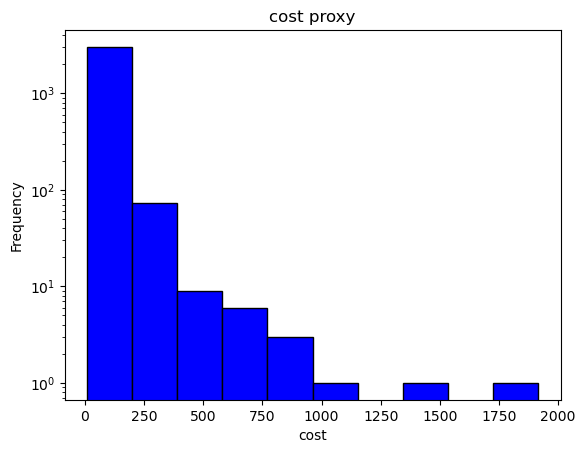

In [80]:
plt.hist(cont_PU['cost'], bins=10, color='blue', edgecolor='black')

# Adding labels and title
plt.xlabel('cost')
plt.ylabel('Frequency')
plt.title('cost proxy')
plt.yscale('log')

# Show the plot
plt.show()

In [81]:
cont_PU.index.names = ['id']

In [83]:
cont_PU[['cost','status']].to_csv(ff('input\\pu.dat'))
#cont_PU[['geometry']].to_file(ff('pulayer\\pulayer.shp'))

In [84]:
#pd.DataFrame(data=values, index=indices, columns=['col1', 'col2', 'col3'])
sp = pd.DataFrame(index = range(1,len(np.unique(r[r != 0]))+1))
sp.index.names = ['id']


In [85]:
groups = pd.read_csv(ff('forestGroupCodes.csv'))

In [86]:
groups = groups.set_index(groups.index + 1)

In [87]:
sp['prop'] = 0.5
sp['spf'] = 1
sp['name'] = groups['text']

In [88]:
sp[['prop','spf','name']].to_csv(ff('input\\spec.dat'))


In [89]:
sp

,prop,spf,name
id,,,
1,0.5,1,White Red Jack Pine Group
2,0.5,1,Spruce Fir Group
3,0.5,1,Longleaf Slash Pine Group
4,0.5,1,Loblolly Shortleaf Pine Group
5,0.5,1,Pinyon Juniper Group
6,0.5,1,Douglas fir Group
7,0.5,1,Ponderosa Pine Group
8,0.5,1,Western White Pine Group
9,0.5,1,Fir Spruce Mountain Hemlock Group


In [90]:
pu_x_sp = contPlus.copy()

In [91]:
for i in range(1,len(np.unique(r[r != 0]))+1):
    value = np.unique(r[r != 0]).astype('str')[i-1]
    pu_x_sp[i] = pu_x_sp['forestPixArea' + value]*pu_x_sp['biomass_density']

In [92]:
puvspr = pu_x_sp[range(1,len(np.unique(r[r != 0]))+1)].stack().rename('amount').reset_index()

In [93]:
puvspr = puvspr.rename(columns={"level_1": "species",
                                "FIPS": "pu"})

In [94]:
# puvspr[['species','pu','amount']].round(1).head()
puvspr = puvspr[puvspr['amount'] != 0]
puvspr['amount'] = puvspr['amount'].astype('float').round(1)
puvspr = puvspr[['species','pu','amount']]
puvspr.to_csv(ff('input\\puvspr.dat'),index = False)

In [95]:
pu = pd.read_csv(ff('input\\pu.dat'))
spec = pd.read_csv(ff('input\\spec.dat'))
puvspr = pd.read_csv(ff('input\\puvspr.dat'))
bound = pd.read_csv(ff('input\\bound.dat'))

In [96]:
#pu.head() # round cost
#spec.head()
#puvspr.head()
#bound.head()
pu['id'] = pu['id'].astype('str').str.zfill(5)
pu = pu.set_index('id')


In [97]:
pu.head()

,cost,status
id,,
31039,22.360,0
53069,47.571,0
35011,31.100,0
31109,71.681,0
31129,27.331,0


In [98]:
def run_marxan(folder):
    marxan_command = "Marxan_x64.exe"
    os.chdir(folder)
    return Popen(marxan_command, shell = True).wait()
    
run_marxan(ff(''))

0

In [99]:
# blm = 0.001
# change_marxan_parameters(
#     wf('mun\\input.dat'), {'BLM': blm, 'NUMREPS': 500}
# )
# run_marxan(wf('mun'))


In [100]:
pulayer = gpd.read_file(ff('pulayer\\pulayer.shp'))
pulayer['id'] = pulayer['id'].astype('str').str.zfill(5)

pulayer = pulayer.set_index('id')

In [101]:
best = pd.read_csv(ff('output\\output_best.csv'))
ssoln = pd.read_csv(ff('output\\output_ssoln.csv'))


In [102]:
ssoln.head()

,planning_unit,number
0,54099,135
1,48227,0
2,28089,241
3,27135,57
4,13123,42


In [103]:
ssoln['planning_unit'] = ssoln['planning_unit'].astype('str').str.zfill(5)
best['PUID'] = best['PUID'].astype('str').str.zfill(5)


In [104]:
best = best.set_index('PUID')
bestlayer = pulayer.join(best)
bestlayer = bestlayer.join(pu)

In [105]:
ssoln = ssoln.set_index('planning_unit')
ssolnlayer = pulayer.join(ssoln)

ssolnlayer = ssolnlayer.join(pu)

In [106]:
bestlayer.head()

,geometry,SOLUTION,cost,status
id,,,,
31039,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",0,22.360,0
53069,"POLYGON ((-123.72755 46.26449, -123.72755 46.2...",0,47.571,0
35011,"POLYGON ((-104.89337 34.08894, -104.89337 34.0...",0,31.100,0
31109,"POLYGON ((-96.68493 40.52330, -96.69219 40.523...",0,71.681,0
31129,"POLYGON ((-98.27370 40.11840, -98.27374 40.122...",0,27.331,0


In [107]:
#ssolnlayer['geometry'] = pulayer['geometry']

In [108]:
ssolnlayer.head()

,geometry,number,cost,status
id,,,,
31039,"POLYGON ((-96.55515 41.91587, -96.55515 41.914...",0,22.360,0
53069,"POLYGON ((-123.72755 46.26449, -123.72755 46.2...",73,47.571,0
35011,"POLYGON ((-104.89337 34.08894, -104.89337 34.0...",50,31.100,0
31109,"POLYGON ((-96.68493 40.52330, -96.69219 40.523...",0,71.681,0
31129,"POLYGON ((-98.27370 40.11840, -98.27374 40.122...",14,27.331,0


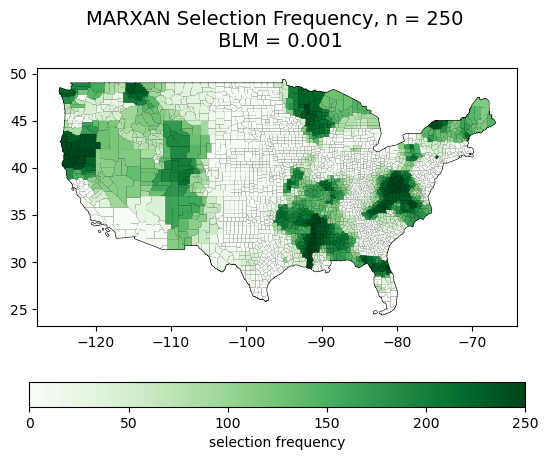

In [109]:
fig, ax = plt.subplots()

pulayer.plot(
    color = 'none',
    edgecolor = 'black',\
    linewidth = .85,
    figsize = (25,20),
    ax = ax
)
ssolnlayer.plot(
    cmap = 'Greens',
    ax = ax,
    column = 'number',
    legend = True,
    legend_kwds = {"label":"selection frequency",
                   "location":'bottom'}
)



ax.set_title("MARXAN Selection Frequency, n = 250 \n BLM = 0.001", pad = 15, fontsize = 14)


filepath = ff('selection_frequency_american_forests.png')
plt.savefig(filepath, dpi = 300)


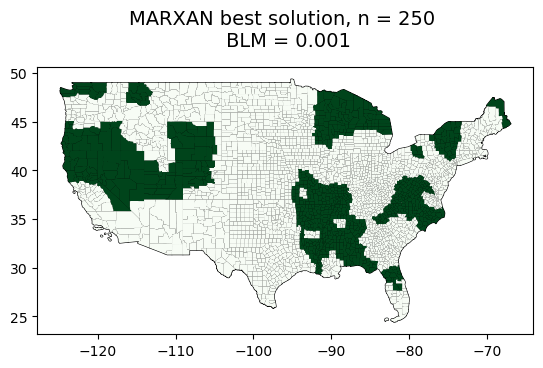

In [110]:
fig, ax = plt.subplots()

pulayer.plot(
    color = 'none',
    edgecolor = 'black',\
    linewidth = .85,
    figsize = (25,20),
    ax = ax
)
bestlayer.plot(
    cmap = 'Greens',
    ax = ax,
    column = 'SOLUTION',
    legend = False,
    legend_kwds = {"label":"final selection",
                   "location":'bottom'}
)



ax.set_title("MARXAN best solution, n = 250 \n BLM = 0.001", pad = 15, fontsize = 14)


filepath = ff('best_solution_american_forests.png')
plt.savefig(filepath, dpi = 300)

In [111]:
selectionLayer = bestlayer[bestlayer['SOLUTION']==1]

In [112]:
selectionLayer['cost'].sum() # total cost

48527.176999999996